In [76]:
from pandas import read_csv
import matplotlib.pyplot as plt
import numpy as np
import more_itertools as mit
from scipy import interpolate

In [77]:
df = read_csv('2kg(2).csv')
df.head()

,Unnamed: 0,Load Cell 1,Load Cell 2,Load Cell 3,Load Cell 4
0,0,150550,157438,-8081,301578
1,1,150585,157232,-7919,301522
2,2,150279,157328,-7971,301630
3,3,150399,157469,-8056,301707
4,4,150431,157475,-8161,301636


In [78]:
col = 'Load Cell 1'
filter_param1 = -3500
filter_param2 = -2000
y = df[col]

y = y.replace(to_replace='False', value=np.nan).map(float)
z = y.copy()
x = np.linspace(0, len(y)-1, len(y))


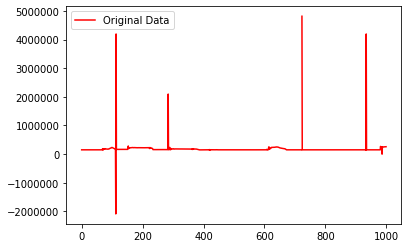

In [79]:
plt.plot(x,y,'r',label='Original Data')
plt.legend()
plt.show()

In [80]:
NaNs = np.where(np.isnan(y))[0]
len(NaNs)

3

In [81]:
delta_y = np.asarray([y.iloc[i+1]-y.iloc[i] for i in range(len(y)-1)])


In [82]:
spikes = np.where(delta_y < filter_param1)[0]
len(spikes)

C:\Users\mtirb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


65

In [83]:
spikes_abs = np.where(abs(delta_y) > abs(filter_param1))[0]
len(spikes_abs)

C:\Users\mtirb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


124

### Method 1: Using original method of delta_y & delta_y2

In [84]:
anomalies = np.sort(np.unique(np.concatenate((spikes, NaNs))))

for positions in anomalies:
    y[positions] = np.nan

len(anomalies)

68

delta_y and NaNs removed

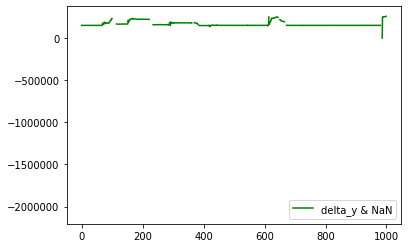

In [85]:
plt.plot(x,y,'g',label='delta_y & NaN')
plt.legend()
plt.show()

In [86]:
delta_y2 = np.asarray([y[i]-y[i+1] for i in range(len(y)-1)])
spikes2 = (np.where(delta_y2 < filter_param2)[0])
len(spikes2)

C:\Users\mtirb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


44

In [87]:
for positions in spikes2:
    y[positions] = np.nan

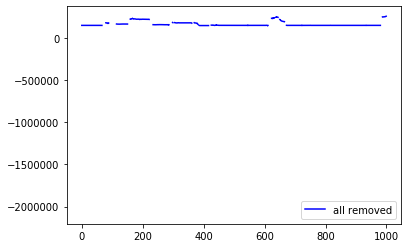

In [88]:
plt.plot(x,y,'b',label='all removed')
plt.legend()
plt.show()

In [89]:
all_anomalies = np.sort(np.concatenate((anomalies,spikes2)))

# group up indicies of consecutive anomalies
grouped = [list(group) for group in mit.consecutive_groups(all_anomalies)]

# do stuff in anomaly indicies depending on if they are single or 
# consecutive
for sections in grouped:
    
    # solo anomalies
    if len(sections) == 1:
        index = sections[0]
        # Replace with average of neighbours
        y[index] = 0.5*(y[index+1]+y[index-1])
    
    # consecutive anomalies
    else:
        lower_index = sections[0]
        upper_index = sections[-1]
        
        # take slice of original data for y vals around the NaN values
        y_temp = np.array(y[lower_index-3: upper_index+2]) 
        x_temp = np.arange(0,len(y_temp))

        
        # Find NaNs in y_temp (must be a quicker way 
        #    bc they have already been found)
        find_NaNs = np.argwhere(np.isnan(y_temp))
        
        # Get rid of array of arrays
        find_NaNs = np.concatenate(find_NaNs, axis=0)
        
        # Delete NaN rows for x and y 
        x_temp = np.delete(x_temp,find_NaNs)
        y_temp = np.delete(y_temp,find_NaNs)
        
        # Interpolate stats on slice of data
        f = interpolate.interp1d(x_temp, y_temp, kind='slinear')
        
        # Calculate NaN replacements by feeding in their x values
        interpolated_y = list(f(find_NaNs))   # use interpolation function returned by `interp1d`

        # Finally, replace NaN values with interpolated values            
        y[lower_index:upper_index+1] = interpolated_y 


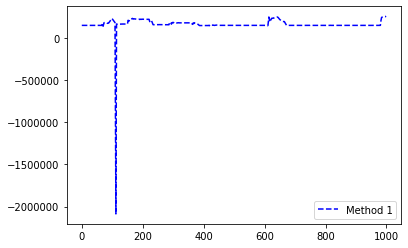

In [90]:
plt.plot(x,y,'--b', label='Method 1')
plt.legend()
plt.show()

In [97]:
spikes_abs = np.where(abs(delta_y) > abs(filter_param1))[0]
anomalies = np.sort(np.unique(np.concatenate((spikes_abs, NaNs))))
print(len(spikes_abs), len(NaNs), len(anomalies))
spikes_abs

124 3 127


C:\Users\mtirb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([ 67,  68,  69,  70,  71,  72,  73,  74,  75,  77,  78,  89,  91,
        93,  94,  96,  97,  98, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 110, 111, 112, 113, 151, 152, 153, 154, 156, 157, 158, 163,
       221, 222, 223, 224, 225, 226, 228, 229, 230, 231, 232, 233, 283,
       284, 287, 288, 289, 290, 291, 292, 293, 294, 295, 297, 299, 300,
       302, 304, 361, 362, 363, 364, 365, 366, 367, 368, 378, 382, 383,
       384, 417, 418, 419, 420, 421, 422, 423, 544, 545, 607, 608, 609,
       612, 613, 615, 616, 617, 618, 619, 621, 622, 630, 634, 639, 645,
       646, 647, 648, 649, 652, 653, 666, 667, 668, 669, 670, 671, 723,
       933, 934, 980, 981, 984, 985, 986], dtype=int64)

In [92]:
for positions in anomalies:
    z[positions] = np.nan

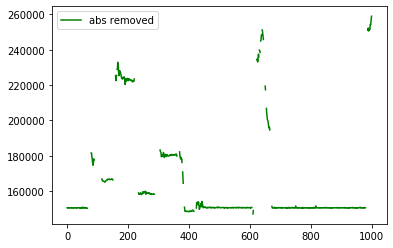

In [93]:
plt.plot(x,z,'g',label='abs removed')
plt.legend()
plt.show()

In [94]:
# group up indicies of consecutive anomalies
grouped = [list(group) for group in mit.consecutive_groups(anomalies)]

# do stuff in anomaly indicies depending on if they are single or 
# consecutive
for sections in grouped:
    
    # solo anomalies
    if len(sections) == 1:
        index = sections[0]
        # Replace with average of neighbours
        z[index] = 0.5*(z[index+1]+z[index-1])
    
    # consecutive anomalies
    else:
        lower_index = sections[0]
        upper_index = sections[-1]
        
        # take slice of original data for y vals around the NaN values
        z_temp = np.array(z[lower_index-3: upper_index+2]) 
        x_temp = np.arange(0,len(z_temp))

        
        # Find NaNs in y_temp (must be a quicker way 
        #    bc they have already been found)
        find_NaNs = np.argwhere(np.isnan(z_temp))
        
        # Get rid of array of arrays
        find_NaNs = np.concatenate(find_NaNs, axis=0)
        
        # Delete NaN rows for x and y 
        x_temp = np.delete(x_temp,find_NaNs)
        z_temp = np.delete(z_temp,find_NaNs)
        
        # Interpolate stats on slice of data
        f = interpolate.interp1d(x_temp, z_temp, kind='slinear')
        
        # Calculate NaN replacements by feeding in their x values
        interpolated_z = list(f(find_NaNs))   # use interpolation function returned by `interp1d`

        # Finally, replace NaN values with interpolated values            
        z[lower_index:upper_index+1] = interpolated_z 

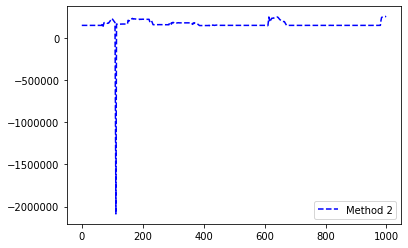

In [95]:
plt.plot(x,y,'--b', label='Method 2')
plt.legend()
plt.show()

In [96]:
np.where((np.asarray(z)-np.asarray(y))<0)

(array([ 67,  68,  73,  74,  75,  86,  89,  90,  91,  92,  93,  94, 151,
        152, 153, 154, 165, 228, 229, 230, 231, 232, 233, 283, 284, 287,
        288, 289, 290, 291, 292, 293, 417, 418, 441, 544, 545, 607, 608,
        609, 620, 621, 622, 626, 633, 634, 636, 983, 984, 985, 986],
       dtype=int64),)